In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math

In [3]:
h = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h.groups['africa']

In [28]:
#Retrieving the data from nc
reflectance = africa.variables['Reflectance'][:]  # Shape: (1, 336, 448, 692)
albedo = africa.variables['surface_albedo'][:]  # Shape: (1, 336, 448)
SZA = africa.variables['SZA'][:]  # Shape: (1, 336, 448)
VZA = africa.variables['VZA'][:]  # Shape: (1, 336, 448)

reflect = []
albd = []
sza = []
vza = []
spectchannel = []
transmitance = []
for n in range(336): 
    for p in range(271, 471):  # represent wavelengths 734-758nm (view Reflectance_wl) ---took second half 
        reflectance_val = africa.variables['Reflectance'][0, n, 2, p].data.tolist() #224 middle ground pixel
        albedo_val = africa.variables['surface_albedo'][0, n, 2].data.tolist() 
        #SZA_val = africa.variables['SZA'][0, n, 224].data.tolist()   
        #VZA_val = africa.variables['VZA'][0, n, 224].data.tolist()   

        if africa.variables['CloudFraction'][0,n,2].data <0.4:# and africa.variables['SurfaceClassification'][0,n,224].data =148:
            
            transmitance.append(reflectance_val/albedo_val)
            #reflect.append(reflectance_val)
            #albd.append(albedo_val)
            #sza.append(SZA_val)
            #vza.append(VZA_val)
            #spectchannel.append(p)
        else: 
            continue 

#len(reflect), len(albd), len(sza), len(vza), len(spectchannel), 
len(transmitance) 

(0, 0, 0, 0, 0, 58800)

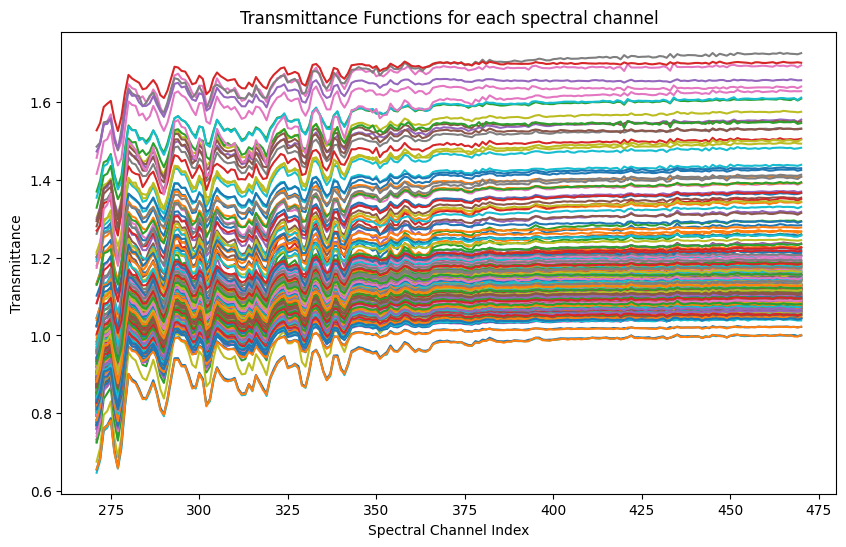

In [30]:
matrix = np.reshape(transmitance, (200, 294), order='F').T

x_axis = list(range(271, 471))

plt.figure(figsize=(10, 6))
for i in range(294):
    plt.plot(x_axis, matrix[i], label=f"Vector {i+1}")

plt.xlabel("Spectral Channel Index")
plt.ylabel("Transmittance")
plt.title("Transmittance Functions for each spectral channel")
plt.show()

In [31]:
#Attempt at lowering dimension...ONLY makes sense when taking one pixel (since we dont do the matrix thing)

# Convert to PyTorch tensors
lambda_tensor = torch.tensor(spectchannel, dtype=torch.float32).view(-1, 1)
T_tensor = torch.tensor(transmitance, dtype=torch.float32).view(-1, 1)
#normalise so NN performs better 
#lambda_tensor = (lambda_tensor - lambda_tensor.mean()) / lambda_tensor.std()
#T_tensor = (T_tensor - T_tensor.mean()) / T_tensor.std()

# Define neural network
class T_Predictor(nn.Module):
    def __init__(self):
        super(T_Predictor, self).__init__()
        self.fc1 = nn.Linear(1, 50)  
        self.fc2 = nn.Linear(50, 50) 
        self.fc3 = nn.Linear(50, 50)  
        self.fc4 = nn.Linear(50, 1)  
        self.activation = nn.ReLU()  

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation in output layer (regression problem)
        return x

# Initialize the model
model = T_Predictor()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(lambda_tensor)
    loss = criterion(predictions, T_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Make predictions
with torch.no_grad():
    T_pred = model(lambda_tensor)

#T_pred_denorm = T_pred * T_tensor.std() + T_tensor.mean()  # Convert back to original scale
#spectchannel_denorm = lambda_tensor * lambda_tensor.std() + lambda_tensor.mean()

# Plot results
import matplotlib.pyplot as plt
plt.scatter(spectchannel, transmitance, label="True T(lambda)", color="blue")
plt.plot(spectchannel, T_pred.numpy(), label="Predicted T(lambda)", color="red")
plt.xlabel("Lambda")
plt.ylabel("T(lambda)")
plt.legend()
plt.show()

/home/carmen/pythonProject1/sif_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([58800, 1])) that is different to the input size (torch.Size([0, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (58800) at non-singleton dimension 0

In [ ]:
####Atempt repeat PCA with NN autoencoder // Transmitance tought as a matrix now.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim=294, latent_dim=10):
        super(LinearAutoencoder, self).__init__()
        # Encoder: reduce dimension from 200 to 10
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, latent_dim)  # Bottleneck: 10 neurons
        )
        # Decoder: reconstruct from latent dimension back to 200
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#(336 functions, each 200-dim) from transmitance vector 
matrix = np.reshape(transmitance, (200, 294), order='F')
data = torch.tensor(matrix, dtype=torch.float32)

# Initialize model, loss and optimizer
model = LinearAutoencoder(input_dim=294, latent_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# After training, extract the latent representation
with torch.no_grad():
    latent_representation = model.encoder(data)
print("Latent representation shape:", latent_representation.shape)  # Should be [336, 10]

Epoch 0, Loss: 1.3408
Epoch 100, Loss: 0.0352
Epoch 200, Loss: 0.0029
Epoch 300, Loss: 0.0029
Epoch 400, Loss: 0.0029
Epoch 500, Loss: 0.0029
Epoch 600, Loss: 0.0029
Epoch 700, Loss: 0.0029
Epoch 800, Loss: 0.0029
Epoch 900, Loss: 0.0029
Latent representation shape: torch.Size([200, 10])


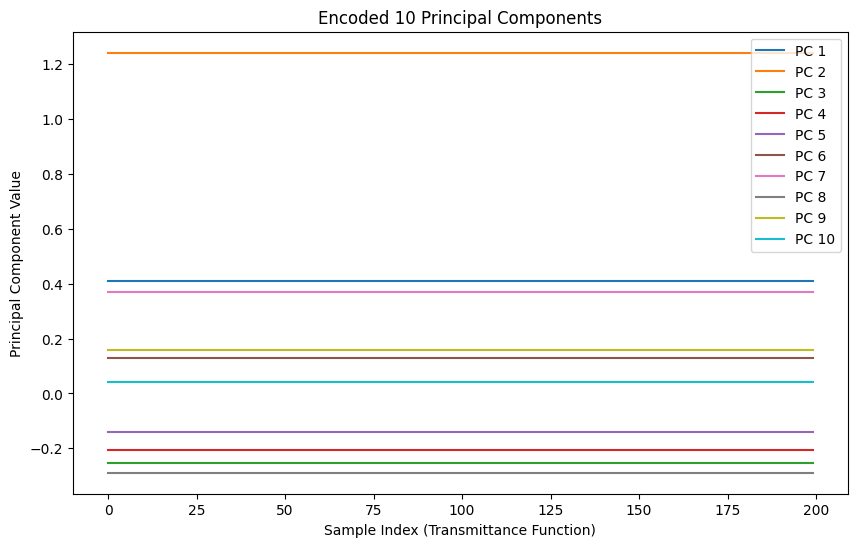

In [20]:
#Plot 10PC
latent_np = latent_representation.detach().numpy()  # Shape: (200, 10)

# X-axis: Sample indices (each row represents one transmittance function)
x_axis = np.arange(200)

# Plot each principal component
plt.figure(figsize=(10, 6))
for i in range(10):  # Loop over 10 PCs
    plt.plot(x_axis, latent_np[:, i], label=f"PC {i+1}")

plt.xlabel("Sample Index (Transmittance Function)")
plt.ylabel("Principal Component Value")
plt.title("Encoded 10 Principal Components")
plt.legend()
plt.show()
